In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.1


In [4]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np


In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
import import_ipynb
from color_segs import *

importing Jupyter notebook from color_segs.ipynb
sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [7]:
class_names = ['sky','building','column/pole','road','side walk','vegetation','traffic light','fence','vehicle','pedestrian','byciclist','void']

In [8]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
    
    print(1)
    
    # Load images to tensors
    img_raw       = tf.io.read_file(t_filename)
    anno_raw      = tf.io.read_file(a_filename)
    image         = tf.image.decode_jpeg(img_raw) # (hxwx3)
    annotation    = tf.image.decode_jpeg(anno_raw)# (hxwx1)
    # (hxwx1) --> Just ints bw 0-11(for class_names) for each pixel in image, the 1 doesnot really try to monochrome,even though 
    # the low values of classnames from 0 to 11 leave  dull black hues.
    # In open CV if you load a monochrome image you get hxw just 2 dims
    
    #Resize and then reshape original image
    img_resized = tf.image.resize(image,(height,width,))
    img_reshaped = tf.reshape(img_resized,(height,width,3,))
    
    #Resize and then reshape annotated gt image
    annotation_resized   = tf.image.resize(annotation,(height,width,))
    annotation_resized   = tf.cast(annotation_resized, dtype=tf.int32)
    annotation_reshaped  = tf.reshape(annotation_resized,(height,width,1))
    
    stack_list = []
    
    #Reshape segmentation masks
    for c in range(len(class_names)):
        mask = tf.equal(annotation_reshaped[:,:,0],tf.constant(c))# True and falses bool array
        stack_list.append(tf.cast(mask,dtype=tf.int32)) # The cast changes bools(Tr/False) to 1s and 0s

        
    annotation_reshaped_pixelclass_ohed = tf.stack(stack_list, axis =2 )# 224x223x12 each pixel gets one hot encoded to represnt one of 12 classes 
    #any row in the 223x12 will have 11 zeroes and 1 one decnoting wich class the pixel belongs to
    
    print("Printing for understanding what we just did")
    print("Shape of img_raw                  ", img_raw.shape)
    print("Shape of anno_raw                 ", anno_raw.shape)
    print("Shape of image                    ", image.shape)
    print("Shape of annotation               ", annotation.shape)
    print("Shape of img_resized              ", img_resized.shape)
    print("Shape of img_reshaped             ", img_reshaped.shape)
    print("Shape of annotation_resized       ", annotation_resized.shape)
    print("Shape of annotation_reshaped      ", annotation_reshaped.shape)
    print("Shape of mask bools               ", mask.shape)
    print("Lenth of stack_list                ", len(stack_list))
    print("Shape of each array in stack_list ", stack_list[0].shape)
    print("Shape of annotation_reshaped_pixelclass_ohed", annotation_reshaped_pixelclass_ohed.shape)
#     print(np.unique(mask))
#     print(np.unique(stack_list))
#     print(np.unique(annotation_reshaped_pixelclass_ohed))
    
#     Normalize pixels in input image
    img_reshaped = img_reshaped/127.5
    img_reshaped -= 1

    
    
    #returning a bunch but will use img_reshaped and annotation_reshaped_pixelclass_ohed
#     return img_raw,anno_raw,image,annotation,img_reshaped,annotation_reshaped,annotation_reshaped_pixelclass_ohed
    return img_reshaped,annotation_reshaped_pixelclass_ohed

In [62]:
t_filename = r"C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\dataset1\images_prepped_train\0001TP_006690.png"
a_filename = r"C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\dataset1\annotations_prepped_train\0001TP_006690.png"

# img_raw,anno_raw,image,annotation,img_reshaped,annotation_reshaped,annotation_reshaped_pixelclass_ohed = map_filename_to_image_and_mask(t_filename, a_filename)

In [9]:
BATCH_SIZE = 64

def get_dataset_slice_paths(image_dir, label_map_dir):
    
    image_file_list = os.listdir(image_dir)
    label_map_file_list = os.listdir(label_map_dir)
    image_paths = [os.path.join(image_dir,fname) for fname in image_file_list]
    label_map_paths = [os.path.join(label_map_dir,fname) for fname in label_map_file_list]
    
    return image_paths,label_map_paths #list of paths of each image file and label map file

In [10]:
def get_training_datasets(image_paths, label_map_paths):
    
    training_dataset = tf.data.Dataset.from_tensor_slices((image_paths,label_map_paths))
    training_dataset = training_dataset.map(map_filename_to_image_and_mask)
    training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration = True)
    training_dataset = training_dataset.batch(BATCH_SIZE)
    training_dataset = training_dataset.repeat()
    training_dataset = training_dataset.prefetch(-1)
    
    return training_dataset

tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label
https://www.tensorflow.org/guide/data

In [11]:
def get_validation_datasets(image_paths, label_map_paths):
    validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths,label_map_paths))
    validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.repeat()
    
    return validation_dataset

In [12]:
tr_image_dir      = r"C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\dataset1\images_prepped_train"
tr_label_map_dir  = r"C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\dataset1\annotations_prepped_train"
val_image_dir     = r"C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\dataset1\images_prepped_test"
val_label_map_dir = r"C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\dataset1\annotations_prepped_test"

training_image_paths  , training_label_map_paths   = get_dataset_slice_paths(tr_image_dir,tr_label_map_dir)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(val_image_dir,val_label_map_dir)

In [13]:
len(training_image_paths),len(training_label_map_paths),len(validation_image_paths),len(validation_label_map_paths)

(367, 367, 101, 101)

In [14]:
training_image_paths

['C:\\Users\\cvsk7\\OneDrive\\Sturctured Content\\My Projects\\Quantization checks\\dataset1\\images_prepped_train\\0001TP_006690.png',
 'C:\\Users\\cvsk7\\OneDrive\\Sturctured Content\\My Projects\\Quantization checks\\dataset1\\images_prepped_train\\0001TP_006720.png',
 'C:\\Users\\cvsk7\\OneDrive\\Sturctured Content\\My Projects\\Quantization checks\\dataset1\\images_prepped_train\\0001TP_006750.png',
 'C:\\Users\\cvsk7\\OneDrive\\Sturctured Content\\My Projects\\Quantization checks\\dataset1\\images_prepped_train\\0001TP_006780.png',
 'C:\\Users\\cvsk7\\OneDrive\\Sturctured Content\\My Projects\\Quantization checks\\dataset1\\images_prepped_train\\0001TP_006810.png',
 'C:\\Users\\cvsk7\\OneDrive\\Sturctured Content\\My Projects\\Quantization checks\\dataset1\\images_prepped_train\\0001TP_006840.png',
 'C:\\Users\\cvsk7\\OneDrive\\Sturctured Content\\My Projects\\Quantization checks\\dataset1\\images_prepped_train\\0001TP_006870.png',
 'C:\\Users\\cvsk7\\OneDrive\\Sturctured Content

In [15]:
training_dataset   = get_training_datasets(training_image_paths,training_label_map_paths)
validation_dataset = get_validation_datasets(validation_image_paths, validation_label_map_paths)

1
Printing for understanding what we just did
Shape of img_raw                   ()
Shape of anno_raw                  ()
Shape of image                     (None, None, None)
Shape of annotation                (None, None, None)
Shape of img_resized               (224, 224, None)
Shape of img_reshaped              (224, 224, 3)
Shape of annotation_resized        (224, 224, None)
Shape of annotation_reshaped       (224, 224, 1)
Shape of mask bools                (224, 224)
Lenth of stack_list                 12
Shape of each array in stack_list  (224, 224)
Shape of annotation_reshaped_pixelclass_ohed (224, 224, 12)
1
Printing for understanding what we just did
Shape of img_raw                   ()
Shape of anno_raw                  ()
Shape of image                     (None, None, None)
Shape of annotation                (None, None, None)
Shape of img_resized               (224, 224, None)
Shape of img_reshaped              (224, 224, 3)
Shape of annotation_resized        (224, 224, 

In [16]:
training_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 12)), types: (tf.float32, tf.int32)>

In [17]:
validation_dataset

<RepeatDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 12)), types: (tf.float32, tf.int32)>

In [106]:
# len(training_dataset), cardinality dont work
#Dont execute this code- takes for ever, may be infinite dataset DOUBT
i = 1
for element in training_dataset:
    i +=1
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

KeyboardInterrupt: 

In [33]:
for element in training_dataset:
    print(len(element))
    print(element[0].shape)
    print(element[1].shape)
    print("Each element in dataset has 2 things : 1 the image itself (batch size # of images) and 2 the annotated label mask with each    pixel onehotted to 12 classes")
    break

2
(64, 224, 224, 3)
(64, 224, 224, 12)
Each element in dataset has 2 things : 1 the image itself (batch size # of images) and 2 the annotated label mask with each    pixel onehotted to 12 classes


## Color and Visualize

In [24]:
import seaborn as sns
class_names = ['sky','building','column/pole','road','side walk','vegetation','traffic light','fence','vehicle','pedestrian','byciclist','void']
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):   
    print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [25]:
# Visualization Utilities

def fuse_with_pil(images):
    
#     '''
#       Creates a blank image and pastes input images

#       Args:
#         images (list of numpy arrays) - numpy array representations of the images to paste

#       Returns:
#         PIL Image object containing the images
#       '''

    widths = (image.shape[1] for image in images)
    heights = (image.shape[0] for image in images)
    total_width = sum(widths)
    max_height = max(heights)

    new_im = PIL.Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        pil_image = PIL.Image.fromarray(np.uint8(im))
        new_im.paste(pil_image, (x_offset,0))
        x_offset += im.shape[1]

    return new_im

In [26]:
def give_color_to_annotation(annotation):
    
# '''
# Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
# the third axis represents the color channel. The label values are multiplied by
# 255 and placed in this axis to give color to the annotation

# Args:
# annotation (numpy array) - label map array

# Returns:
# the annotation array with an additional color channel/axis
# '''
    seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')

    for c in range(12):
        segc = (annotation == c)
        seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
        seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
        seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

    return seg_img

In [27]:
def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
#   '''
#   Displays the images with the ground truth and predicted label maps

#   Args:
#     image (numpy array) -- the input image
#     labelmaps (list of arrays) -- contains the predicted and ground truth label maps
#     titles (list of strings) -- display headings for the images to be displayed
#     iou_list (list of floats) -- the IOU values for each class
#     dice_score_list (list of floats) -- the Dice Score for each vlass
#   '''

    true_img = give_color_to_annotation(labelmaps[1])
    pred_img = give_color_to_annotation(labelmaps[0])

    image = image + 1
    image = image * 127.5
    images = np.uint8([image, pred_img, true_img])

    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list) 

    plt.figure(figsize=(15, 4))

    for idx, im in enumerate(images):
        plt.subplot(1, 3, idx+1)
        if idx == 1:
            plt.xlabel(display_string)
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[idx], fontsize=12)
        plt.imshow(im)

In [28]:
def show_annotation_and_image(image, annotation):
#   '''
#   Displays the image and its annotation side by side

#   Args:
#     image (numpy array) -- the input image
#     annotation (numpy array) -- the label map
#   '''
    new_ann = np.argmax(annotation, axis=2)
    seg_img = give_color_to_annotation(new_ann)

    image = image + 1
    image = image * 127.5
    image = np.uint8(image)
    images = [image, seg_img]

    images = [image, seg_img]
    fused_img = fuse_with_pil(images)
    plt.imshow(fused_img)

In [29]:
def list_show_annotation(dataset):
#   '''
#   Displays images and its annotations side by side

#   Args:
#     dataset (tf Dataset) - batch of images and annotations
#   '''

    ds = dataset.unbatch()
    ds = ds.shuffle(buffer_size=100)

    plt.figure(figsize=(25, 15))
    plt.title("Images And Annotations")
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

    # we set the number of image-annotation pairs to 9
    # feel free to make this a function parameter if you want
    for idx, (image, annotation) in enumerate(ds.take(9)):
        plt.subplot(3, 3, idx + 1)
        plt.yticks([])
        plt.xticks([])
        show_annotation_and_image(image.numpy(), annotation.numpy())

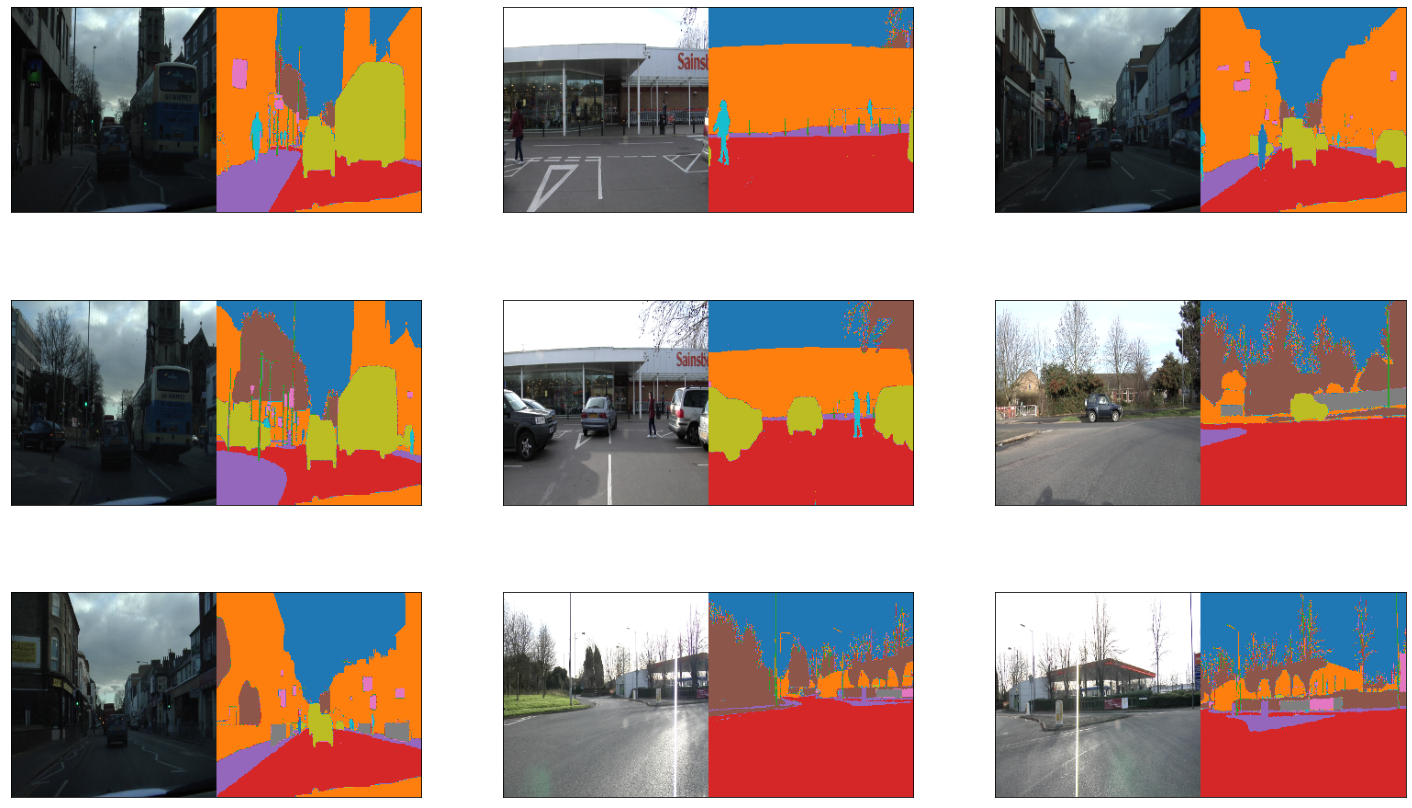

In [30]:
list_show_annotation(training_dataset)

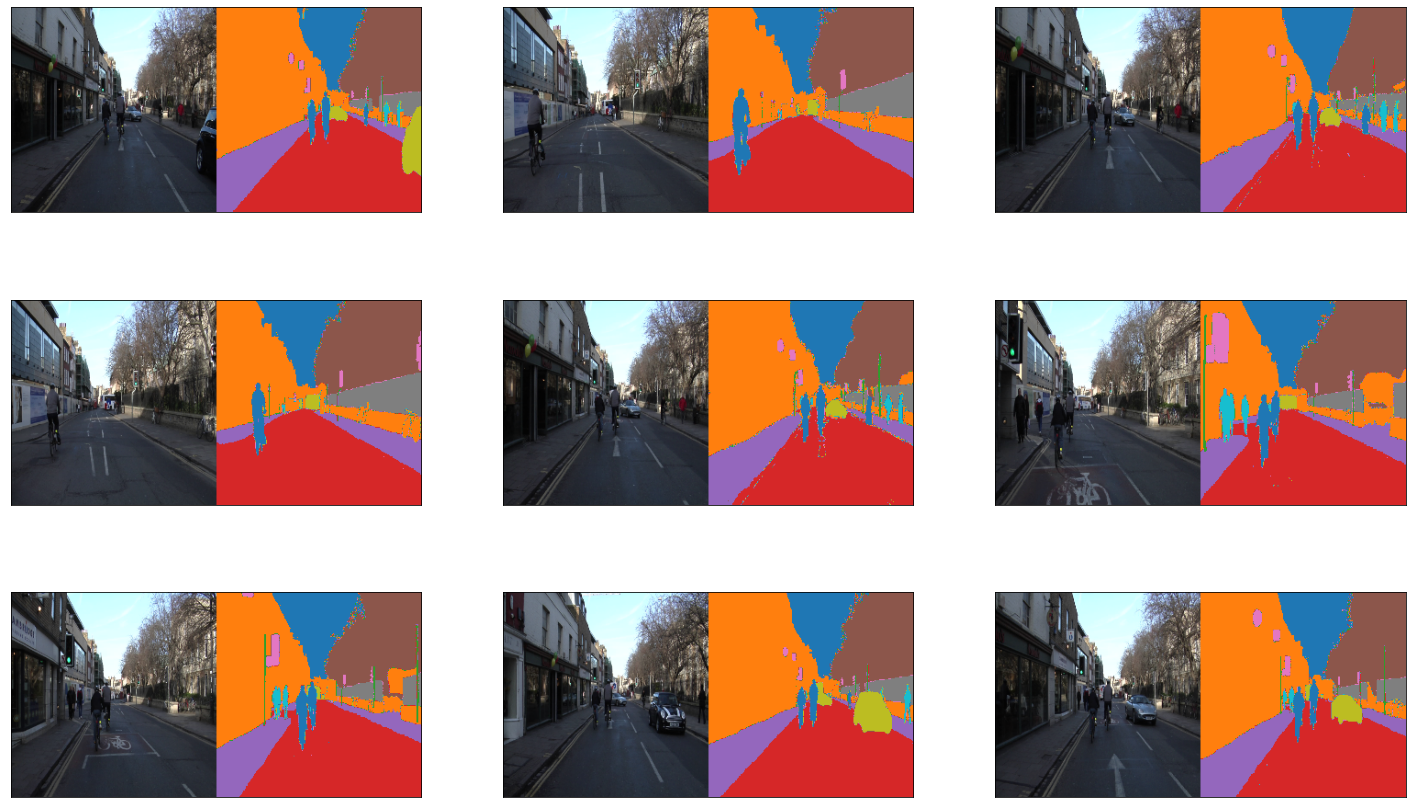

In [31]:
list_show_annotation(validation_dataset)

In [34]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
    
#   '''
#   Defines a block in the VGG network.

#   Args:
#     x (tensor) -- input image
#     n_convs (int) -- number of convolution layers to append
#     filters (int) -- number of filters for the convolution layers
#     activation (string or object) -- activation to use in the convolution
#     pool_size (int) -- size of the pooling layer
#     pool_stride (int) -- stride of the pooling layer
#     block_name (string) -- name of the block

#   Returns:
#     tensor containing the max-pooled output of the convolutions
#   '''

    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, 
                                   padding='same', name="{}_conv{}".format(block_name, i + 1))(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

    return x

In [35]:
vgg_weights_path = r"C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\Pre-trained models\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [36]:
def VGG_16(image_input):
    
#   '''
#   This function defines the VGG encoder.

#   Args:
#     image_input (tensor) - batch of images

#   Returns:
#     tuple of tensors - output of all encoder blocks plus the final convolution layer
#   '''

    # create 5 blocks with increasing filters at each stage. 
    # you will save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.
    x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
    p1= x

    x = block(x,n_convs=2, filters=128, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
    p2 = x

    x = block(x,n_convs=3, filters=256, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
    p3 = x

    x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
    p4 = x

    x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
    p5 = x

    # create the vgg model
    vgg  = tf.keras.Model(image_input , p5)

    # load the pretrained weights you downloaded earlier
    vgg.load_weights(vgg_weights_path) 

    # number of filters for the output convolutional layers
    n = 4096

    # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
    # we can extract more features by chaining two more convolution layers.
    c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

    # return the outputs at each stage. you will only need two of these in this particular exercise 
    # but we included it all in case you want to experiment with other types of decoders.
    return (p1, p2, p3, p4, c7)

In [37]:
def fcn8_decoder(convs, n_classes):
    
#   '''
#   Defines the FCN 8 decoder.

#   Args:
#     convs (tuple of tensors) - output of the encoder network
#     n_classes (int) - number of classes

#   Returns:
#     tensor with shape (height, width, n_classes) containing class probabilities
#   '''

    # unpack the output of the encoder
    f1, f2, f3, f4, f5 = convs

    # upsample the output of the encoder then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

    # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

    # add the results of the upsampling and pool 4 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample the resulting tensor of the operation you just did
    o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o2 = f3
    o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

    # add the results of the upsampling and pool 3 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

    # append a softmax to get the class probabilities
    o = (tf.keras.layers.Activation('softmax'))(o)

    return o

In [38]:
def segmentation_model():
    
#   '''
#   Defines the final segmentation model by chaining together the encoder and decoder.

#   Returns:
#     keras Model that connects the encoder and decoder networks of the segmentation model
#   '''
  
    inputs = tf.keras.layers.Input(shape=(224,224,3,))
    convs = VGG_16(image_input=inputs)
    outputs = fcn8_decoder(convs, 12)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [39]:
# instantiate the model and see how it looks
model = segmentation_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool2 (MaxPooling2D)     (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [58]:
model.save("new.h5")
import os
# os.stat.
localfile = r"new.h5"
stats = os.stat(localfile)
size = stats.st_size
stats
m = 1024**2
print(m)
size/m

1048576


515.329231262207

In [59]:
sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [60]:
# number of training images
train_count = 367

# number of validation images
validation_count = 101

EPOCHS = 170

steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/170
5/5 [==============================] - 256s 51s/step - loss: 2.6861 - accuracy: 0.0872 - val_loss: 2.4881 - val_accuracy: 0.0879
Epoch 2/170
5/5 [==============================] - 257s 51s/step - loss: 2.4862 - accuracy: 0.0890 - val_loss: 2.4852 - val_accuracy: 0.0897
Epoch 3/170
5/5 [==============================] - 254s 51s/step - loss: 2.4843 - accuracy: 0.0904 - val_loss: 2.4844 - val_accuracy: 0.0896
Epoch 4/170
2/5 [===========>..................] - ETA: 1:32 - loss: 2.4837 - accuracy: 0.0911

KeyboardInterrupt: 

In [61]:
def get_images_and_segments_test_arrays():
#   '''
#   Gets a subsample of the val set as your test set

#   Returns:
#     Test set containing ground truth images and label maps
#   '''
    y_true_segments = []
    y_true_images = []
    test_count = 64

    ds = validation_dataset.unbatch()
    ds = ds.batch(101)

    for image, annotation in ds.take(1):
        y_true_images = image
        y_true_segments = annotation


    y_true_segments = y_true_segments[:test_count, : ,: , :]
    y_true_segments = np.argmax(y_true_segments, axis=3)  

    return y_true_images, y_true_segments

In [68]:
# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

In [69]:
# get the model prediction
results = model.predict(validation_dataset, steps=validation_steps)

# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)

In [72]:
np.unique(results)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [73]:
results.shape

(64, 224, 224)

In [74]:
def compute_metrics(y_true, y_pred):
#   '''
#   Computes IOU and Dice Score.

#   Args:
#     y_true (tensor) - ground truth label map
#     y_pred (tensor) - predicted label map
#   '''
  
    class_wise_iou = []
    class_wise_dice_score = []

    smoothening_factor = 0.00001

    for i in range(12):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)

        dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

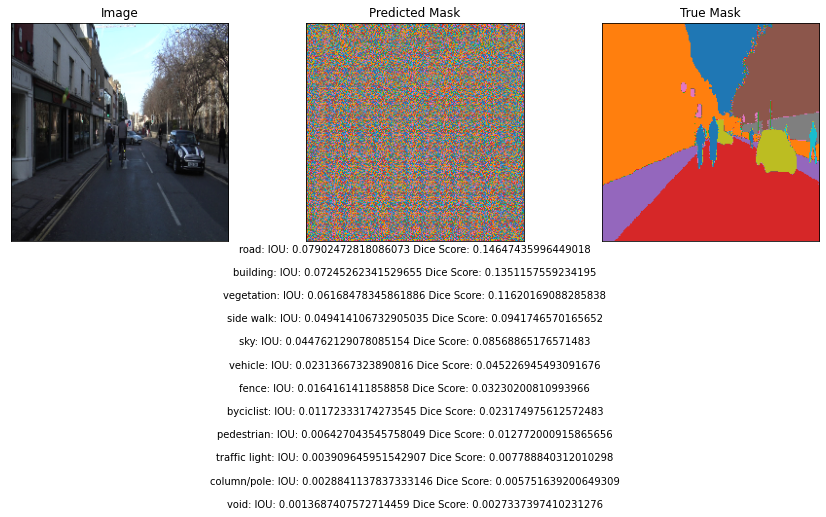

In [75]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 0

# compute metrics
iou, dice_score = compute_metrics(y_true_segments[integer_slider], results[integer_slider])  

# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou, dice_score)

In [76]:
model.save("camvid_iseg_vgg16_epoch3.h5")
import os
# os.stat.
localfile = r"camvid_iseg_vgg16_epoch3.h5"
stats = os.stat(localfile)
size = stats.st_size
stats
m = 1024**2
print(m)
size/m

1048576


1030.6536178588867

In [81]:
os.path.getsize("camvid_iseg_vgg16_epoch3.h5")

1080718648

In [82]:
model_loaded = tf.keras.models.load_model("camvid_iseg_vgg16_epoch3.h5")


## Start Quantize

In [85]:
def quant_hybrid(orig_model, orig_model_path, modelname):
    

    if orig_model:
        converter = tf.lite.TFLiteConverter.from_keras_model(orig_model)
    if orig_model_path:
         converter = tf.lite.TFLiteConverter.from_saved_model(orig_modelpath)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    print('converting to DYNR-Hyb:.25-Quantized model......')


    tflite_quant_model = converter.convert()    
    tflite_models_dir = pathlib.Path(r'C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\Quantized models')
    filename = modelname+'hybrid_.tflite'
    # Save the quantized model:
    tflite_model_quant_file_path = pathlib.PureWindowsPath.joinpath(tflite_models_dir,filename)  
    tflite_model_quant_file_path.write_bytes(tflite_quant_model)

    print("model file name is in ", tflite_model_quant_file_path)
    print(type(tflite_model_quant_file_path))
    
    return tflite_quant_model, tflite_model_quant_file_path

In [87]:
import pathlib
orig_model      = model_loaded
orig_model_path = ''
modelname       = 'camvid_iseg_vgg16_epoch3'
tflite_quant_model, tflite_model_quant_file_path = quant_hybrid(orig_model, orig_model_path, modelname)

converting to DYNR-Hyb:.25-Quantized model......
INFO:tensorflow:Assets written to: C:\Users\cvsk7\AppData\Local\Temp\tmpt9odhht6\assets


INFO:tensorflow:Assets written to: C:\Users\cvsk7\AppData\Local\Temp\tmpt9odhht6\assets


model file name is in  C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\Quantized models\camvid_iseg_vgg16_epoch3hybrid_.tflite
<class 'pathlib.WindowsPath'>


In [92]:
# if (( quant_modelpath != '') & (qmode == 'HYBRID')):
print('inhybrid')
quant_modelpath =str(tflite_model_quant_file_path)# tflite_model_quant_file_path
print(quant_modelpath)
interpreter_hybrid = tf.lite.Interpreter(model_path=str(quant_modelpath)) 
print('inhybrid-loaded')
interpreter_hybrid.allocate_tensors()
print('inhybrid-allocated')
input_index = interpreter_hybrid.get_input_details()[0]["index"]
output_index = interpreter_hybrid.get_output_details()[0]["index"]

# for i,sample in enumerate(samples): 
#     sample = np.expand_dims(sample, axis=0).astype(np.float32)  
#     print('inhybrid-expanded')
#     interpreter_hybrid.set_tensor(input_index, sample)#-->ValueError: Cannot set tensor: Dimension mismatch. Got 224 but expected 1 for dimension 1 of input 0.
#     # so reszing manually and reallocating tensor and then setting input
# #             interpreter_fp16.resize_tensor_input(0, [1, 224, 224, 3], strict=True)
# #             interpreter_fp16.allocate_tensors()
#     print('inhybrid-set tensored')
# #             interpreter_hybrid.set_tensor(input_index, sample)
#     interpreter_hybrid.invoke()
#     print('inhybrid-set invoked')
#     output = interpreter_hybrid.get_tensor(output_index)#output is of shape numpy.ndarray, (1, 1, 1, 2048)
#     print('inhybrid-set output')
#     print(output)
#     print(type(output),output.shape)


inhybrid
C:\Users\cvsk7\OneDrive\Sturctured Content\My Projects\Quantization checks\Quantized models\camvid_iseg_vgg16_epoch3hybrid_.tflite
inhybrid-loaded
inhybrid-allocated
